In [255]:
import json

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm, CenteredNorm
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')

from sklearn.preprocessing import StandardScaler

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
# data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

In [345]:
data.loc[data['Type'] == 'metabolite', 'ID'].unique()

array(['unknown', 'Urocanic acid', 'Uridine', 'Uric acid', 'Tyrosine',
       'Tryptophan', 'Trigonelline', 'Indole-3-acrylic acid', 'Threonine',
       'Threonic acid', 'Taurine', 'Stachydrine', 'Serine', 'Ribose',
       'Quinic acid', 'Pyroglutamic acid', 'Pseudouridine', 'Proline',
       'Pipecolic acid', 'Phenylalanine', 'Phenylacetylglycine',
       'Pentose sugar', 'Ornithine', 'Nicotinamide 1-oxide',
       'Nicotinamide', 'N6,N6,N6-Trimethyl-L-lysine',
       'N3,N4-Dimethyl-L-arginine', 'N-Methyl-2-pyrrolidone',
       'N-Isovalerylglycine', 'N-Acetylornithine',
       'N-Acetylneuraminic acid', 'N-Acetyl-L-aspartic acid',
       'Methylhistidine', 'Methylaminopyrimidine', 'Leucine',
       'Lactic Acid', 'Isoleucine', 'Hydroxycinnamic acid',
       'Hydrocinnamic acid', 'Histidine', 'Hippuric acid', 'Iditol',
       'Hexose sugar', 'Guanidinosuccinic acid', 'Glyceric acid',
       'Glutamine', 'Glutamic acid', 'Glucose', 'Gluconic acid',
       'Ethyl-beta-D-glucuronide', '

In [342]:
ap['FBGweek10']

animal
1060    52.500000
1061    40.000000
1062    40.000000
1063    64.500000
1074    55.000000
1075    67.500000
1076    71.000000
1080    41.500000
1081    73.500000
1082    50.000000
1091    48.500000
1092    51.500000
1093    56.500000
1094    62.500000
1095    55.000000
1096    76.333333
1100          NaN
1101    44.500000
1102    43.333333
Name: FBGweek10, dtype: float64

In [275]:
def parse_lipid(lipid):
    l = lipid.split(' ')
    cls = l[0]
    fa = l[1]
    
    if '-' in fa:
        fa = fa.split('-')[1]
        label = fa.split('-')[0] + '-'
    else:
        label = ''
    if 'd' in fa:
        fa = fa.split('d')[1]
        label = fa.split('d')[0] + 'd'
    else:
        label = ''
        
    fa = [x.split(':') for x in fa.split('_')]
    fa = [[int(x) for x in sublist] for sublist in fa]
    carbons = sum([chain[0] for chain in fa])
    unsat = sum([chain[1] for chain in fa])
    sum_comp = str(carbons) + ':' + str(unsat)
    result = cls + ' ' + label + str(carbons) + ':' + str(unsat)
#     print(lipid, result)
    return cls, label, carbons, unsat, sum_comp, fa

def bin_p_value(pval):
#     if   pval < 0.0001:
#         return '****'
#     if pval < 0.001:
#         return '***'
    if pval < 0.01:
        return '**'
    if pval < 0.05:
        return '*'
#     if pval < 0.05:
#         return 'p < 0.05'
    return 'ns'

In [324]:
d = data[data_cols]
ids = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'unknown')].copy()
ids['fa_carbons'] = ids.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[2])
ids['fa_unsat'] = ids.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[3])
ids['fa_carbon:unsat'] = ids.loc[:, 'ID'].apply(lambda x: parse_lipid(x)[4])
ids['log2 FC'] = ids[rbg_cols].mean(axis=1) - ids[fbg_cols].mean(axis=1)
ids['-log10_pval_interaction'] = -np.log10(ids['qval_sampling:ogtt'])
ids['-log10_pval_ogtt']  = -np.log10(ids['qval_ogtt'])
ids['-log10_pval_sampling'] = -np.log10(ids['qval_sampling'])
ids['pval_asterisks'] = ids['qval_sampling:ogtt'].apply(lambda x: bin_p_value(x))
ids

,unique_id,RT,m/z,adduct,Type,polarity,ID,1102_8_RBG,1093_9_RBG,1060_8_FBG,...,model_param_ogtt,model_param_sampling[T.RBG]:ogtt,fa_carbons,fa_unsat,fa_carbon:unsat,log2 FC,-log10_pval_interaction,-log10_pval_ogtt,-log10_pval_sampling,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
l_5,LysoPC 20:5_1.036_542.32452,1.036,542.32452,NaN,lipid,+,LysoPC 20:5,25.647760,26.973065,23.835084,...,-2.317200e-05,1.078265e-05,20,5,20:5,0.592306,0.293023,1.755738,2.961821,ns
l_6,LysoPC 16:0_1.095_496.33994,1.095,496.33994,NaN,lipid,+,LysoPC 16:0,26.922772,28.708609,26.253075,...,-1.764579e-06,-8.596802e-06,16,0,16:0,0.160012,0.137507,0.194770,0.244461,ns
l_7,LysoPC 18:1_1.137_522.35236,1.137,522.35236,NaN,lipid,+,LysoPC 18:1,23.033801,23.842277,21.278809,...,-1.961566e-05,6.780118e-06,18,1,18:1,1.225050,0.120907,0.996083,6.093187,ns
l_9,LysoPC 22:6_1.289_568.33972,1.289,568.33972,NaN,lipid,+,LysoPC 22:6,24.169049,25.812168,25.394377,...,-5.625473e-06,-4.526247e-06,22,6,22:6,-0.175092,0.125434,0.640544,0.596280,ns
l_10,LysoPC 15:0_1.324_482.32388,1.324,482.32388,NaN,lipid,+,LysoPC 15:0,20.923253,22.214125,20.671309,...,-1.266481e-05,-6.780389e-07,15,0,15:0,0.359271,0.014234,1.378177,1.732673,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_861,TG 57:2_19.582_946.88043,19.582,946.88043,NaN,lipid,+,TG 57:2,19.849247,19.422779,20.153422,...,-9.476374e-06,6.182588e-05,57,2,57:2,0.454954,1.484842,0.862429,0.741361,*
l_863,TG 56:1_19.841_934.88123,19.841,934.88123,NaN,lipid,+,TG 56:1,21.470210,20.888517,20.975758,...,-1.760424e-05,7.800309e-05,56,1,56:1,1.211975,2.356075,1.002770,3.963748,**
l_864,TG 18:2_18:1_24:0_19.865_986.91193,19.865,986.91193,NaN,lipid,+,TG 18:2_18:1_24:0,20.600064,19.856448,19.408564,...,-1.306094e-05,7.646786e-05,60,3,60:3,1.565687,2.194161,1.231176,5.578809,**


In [270]:
# Because some lipid IDs overlap in their sum compositions, add some jitter to the x and y values

for cls in ids['molec_class'].unique():
    print(cls, '\n')
    display(ids.loc[ids['molec_class'] == cls, 'fa_carbon:unsat'].value_counts())

LysoPC 



16:0    3
18:1    3
17:0    2
18:0    2
20:5    1
22:6    1
15:0    1
20:4    1
18:2    1
22:5    1
17:1    1
20:3    1
22:4    1
20:2    1
Name: fa_carbon:unsat, dtype: int64

LysoPE 



18:2    1
16:0    1
18:0    1
Name: fa_carbon:unsat, dtype: int64

AC 



16:0    1
18:1    1
18:0    1
Name: fa_carbon:unsat, dtype: int64

PC 



38:7     4
36:3     4
38:5     3
36:4     3
34:3     2
38:6     2
40:5     2
40:6     2
39:4     2
38:4     2
36:5     2
32:2     1
37:3     1
42:6     1
32:0     1
36:6     1
34:1     1
36:2     1
38:3     1
33:0     1
35:1     1
40:4     1
37:2     1
34:0     1
36:1     1
38:2     1
40:3     1
35:2     1
42:10    1
37:6     1
33:1     1
37:4     1
31:0     1
40:8     1
34:2     1
39:6     1
32:1     1
34:4     1
30:0     1
37:5     1
35:3     1
40:7     1
33:2     1
35:4     1
35:0     1
Name: fa_carbon:unsat, dtype: int64

Alkenyl-DG 



36:5    1
38:6    1
Name: fa_carbon:unsat, dtype: int64

PI 



38:3    2
36:4    1
34:2    1
36:3    1
38:5    1
37:4    1
35:2    1
40:6    1
34:1    1
38:4    1
36:2    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

SM 



40:2    2
41:2    2
40:7    1
42:1    1
41:1    1
43:2    1
40:1    1
42:2    1
39:1    1
42:3    1
38:1    1
32:1    1
37:1    1
36:0    1
36:1    1
35:1    1
36:2    1
34:1    1
33:1    1
36:3    1
34:2    1
43:1    1
Name: fa_carbon:unsat, dtype: int64

Plasmenyl-PC 



38:6    2
34:4    1
36:5    1
40:7    1
32:1    1
36:3    1
40:6    1
38:4    1
34:2    1
36:2    1
34:0    1
Name: fa_carbon:unsat, dtype: int64

Plasmanyl-PC 



38:5    3
36:5    2
38:6    2
36:3    2
34:3    2
34:4    1
34:1    1
36:1    1
40:4    1
42:6    1
40:5    1
36:2    1
38:3    1
32:1    1
32:0    1
38:4    1
40:6    1
34:2    1
36:4    1
33:2    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

Plasmenyl-PE 



40:7    2
38:5    2
36:5    1
38:6    1
36:4    1
36:3    1
34:2    1
40:6    1
38:4    1
34:1    1
36:2    1
40:5    1
42:6    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

PE 



36:4    1
34:2    1
40:6    1
38:4    1
36:2    1
36:1    1
Name: fa_carbon:unsat, dtype: int64

Plasmanyl-PE 



36:4    1
38:5    1
40:6    1
38:4    1
36:2    1
40:5    1
42:6    1
40:4    1
36:1    1
38:2    1
Name: fa_carbon:unsat, dtype: int64

Cer[NS] 



42:2    1
40:1    1
41:1    1
42:1    1
Name: fa_carbon:unsat, dtype: int64

TG 



58:9     3
54:4     3
58:11    3
58:7     3
52:5     2
        ..
48:1     1
46:0     1
52:3     1
49:1     1
54:0     1
Name: fa_carbon:unsat, Length: 81, dtype: int64

CE 



20:5    1
20:4    1
18:2    1
18:1    1
Name: fa_carbon:unsat, dtype: int64

In [273]:
def add_jitter(lipid_class, os): 
    # os = offset for jitter
    tgdf = ids.loc[ids['molec_class'] == lipid_class].copy()
    overlaps = tgdf['fa_carbon:unsat'].value_counts() > 1
    overlaps = overlaps.loc[overlaps == True].index
    for overlap in overlaps: 
        df = tgdf.loc[tgdf['fa_carbon:unsat'] == overlap]
        if len(df) == 4:
            for carbon_offset, unsat_offset, (i, row) in zip([-os,os,os,os], [os,-os,os,-os], df.iterrows()):
                tgdf.loc[i, 'fa_carbons'] = tgdf.loc[i, 'fa_carbons'] + carbon_offset
                tgdf.loc[i, 'fa_unsat'] = tgdf.loc[i, 'fa_unsat'] + unsat_offset
        if len(df) == 3:
            for carbon_offset, unsat_offset, (i, row) in zip([0, -os, os], [os, -os, -os], df.iterrows()):
                tgdf.loc[i, 'fa_carbons'] = tgdf.loc[i, 'fa_carbons'] + carbon_offset
                tgdf.loc[i, 'fa_unsat'] = tgdf.loc[i, 'fa_unsat'] + unsat_offset
        if len(df) == 2:
            for carbon_offset, unsat_offset, (i, row) in zip([-os, os], [0, 0], df.iterrows()):
                tgdf.loc[i, 'fa_carbons'] = tgdf.loc[i, 'fa_carbons'] + carbon_offset
                tgdf.loc[i, 'fa_unsat'] = tgdf.loc[i, 'fa_unsat'] + unsat_offset
    return tgdf
tgdf = add_jitter('TG', 0.15)
pcdf = add_jitter('PC', 0.1)

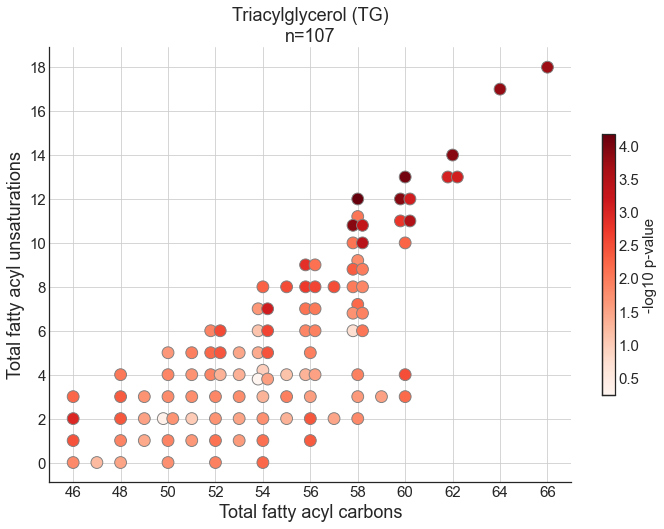

In [338]:
def make_carbon_unsat_plot_pval(lipid_class, jitter_offset, pval):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
    df = add_jitter(lipid_class, os=jitter_offset)
    max_C, min_C = df['fa_carbons'].max(), df['fa_carbons'].min()
    max_unsat, min_unsat = df['fa_unsat'].max(), df['fa_unsat'].min()
#     norm = CenteredNorm(vcenter=0.0, )
    norm = Normalize(vmin=df[pval].min(), vmax=df[pval].max())
    cmap = 'Reds'  # GnBu  viridis_r
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    sns.scatterplot(
        data=df, x='fa_carbons', y='fa_unsat',
    #         size='-log10 p-value', sizes=(10, 200),
    #         size='pval_asterisks', sizes={'ns': 20, '*': 55, '**': 75, '***': 110, '****': 120},
        s=140,
#         style='pval_asterisks', markers={'ns': '^','*':'o', '**': '*'}, sizes={'ns': 100, '*': 100, '**':500},
        hue=pval, 
        hue_norm=norm, 
        palette=cmap,  
#         legend=('brief' if i == 0 else False),
        legend=False,
        edgecolor='gray', ax=ax)
    ax.set_xticks(np.arange(min_C, max_C+1, 2))
    ax.set_xticklabels([int(x) for x in np.arange(min_C, max_C+1, 2)], fontsize=15)
    ax.set_yticks(np.arange(min_unsat, max_unsat+1, 2))
    ax.set_yticklabels([int(x) for x in np.arange(min_unsat, max_unsat+1, 2)], fontsize=15)
    plt.grid(color='#CCCCCC')
#     plt.legend(title='log2 fold change', loc=(1.01, 0.5), markerscale=1.5, fontsize=15, title_fontsize=18)
#     plt.title('Lipids by class significant under glucose tolerance', fontsize=18)
    plt.ylabel('Total fatty acyl unsaturations', fontsize=18)
    plt.xlabel('Total fatty acyl carbons', fontsize=18)
    cb = ax.figure.colorbar(sm, shrink=0.6, fraction=0.1)
    cb.ax.tick_params(labelsize=15)
    cb.set_label(label='-log10 p-value', fontsize=15)
    # plt.tight_layout()
    sns.despine()
    # plt.savefig(r'..\reports\figures\4-5-4\TG_.png', bbox_inches='tight')
make_carbon_unsat_plot_pval('TG', 0.20, '-log10_pval_interaction')

num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
plt.title(f'Triacylglycerol (TG)\nn={num_tg}', fontsize=18)
plt.savefig(r'..\reports\figures\4-5-4\TG_pval_interaction.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\TG_pval_interaction.svg', dpi=150, bbox_inches='tight')

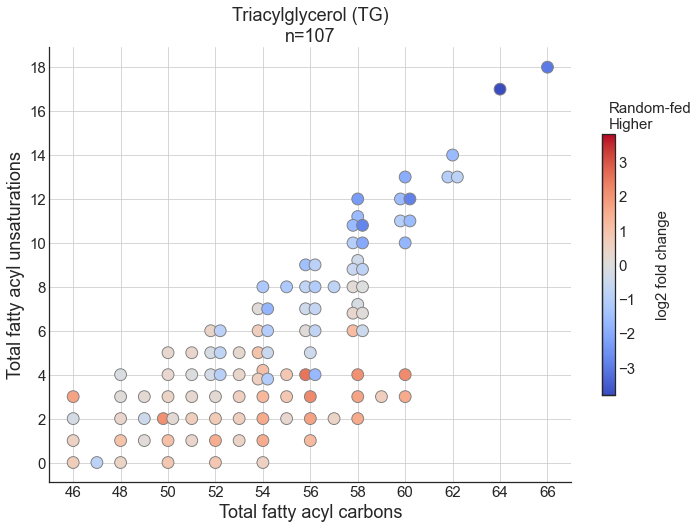

In [337]:
def make_carbon_unsat_plot(lipid_class, jitter_offset):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
    df = add_jitter(lipid_class, os=jitter_offset)
    max_C, min_C = df['fa_carbons'].max(), df['fa_carbons'].min()
    max_unsat, min_unsat = df['fa_unsat'].max(), df['fa_unsat'].min()
    norm = CenteredNorm(vcenter=0.0, 
#                         vmin=df['log2 FC'].min(), vmax=df['log2 FC'].max()
                       )
    cmap = 'coolwarm'  # GnBu  viridis_r
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    sns.scatterplot(
        data=df, x='fa_carbons', y='fa_unsat',
    #         size='-log10 p-value', sizes=(10, 200),
    #         size='pval_asterisks', sizes={'ns': 20, '*': 55, '**': 75, '***': 110, '****': 120},
        s=140,
#             style='pval_asterisks', markers={'ns': '^','*':'o'},
        hue='log2 FC', hue_norm=norm, palette=cmap,  
#         legend=('brief' if i == 0 else False),
        legend=False,
        edgecolor='gray', ax=ax)
    ax.set_xticks(np.arange(min_C, max_C+1, 2))
    ax.set_xticklabels([int(x) for x in np.arange(min_C, max_C+1, 2)], fontsize=15)
    ax.set_yticks(np.arange(min_unsat, max_unsat+1, 2))
    ax.set_yticklabels([int(x) for x in np.arange(min_unsat, max_unsat+1, 2)], fontsize=15)
    plt.grid(color='#CCCCCC')
#     plt.legend(title='log2 fold change', loc=(1.01, 0.5), markerscale=1.5, fontsize=15, title_fontsize=18)
#     plt.title('Lipids by class significant under glucose tolerance', fontsize=18)
    plt.ylabel('Total fatty acyl unsaturations', fontsize=18)
    plt.xlabel('Total fatty acyl carbons', fontsize=18)
    cb = ax.figure.colorbar(sm, shrink=0.6, fraction=0.1)
    cb.ax.tick_params(labelsize=15)
    cb.set_label(label='\nlog2 fold change', fontsize=15)
    cb.ax.set_title('Random-fed\nHigher', fontsize=15, ha='left')
#     plt.text()
#     cb.ax.set_xticks(ticks=[0], labels=['Fasted\nHigher'], fontsize=20)
#     cb.ax.set_xticklabels(ticks=[0], labels=['Fasted\nHigher'], fontsize=20)
    # plt.tight_layout()
    sns.despine()
    
make_carbon_unsat_plot('TG', 0.20)
num_tg = ids.loc[ids['molec_class'] == 'TG'].shape[0]
plt.title(f'Triacylglycerol (TG)\nn={num_tg}', fontsize=18)
plt.savefig(r'..\reports\figures\4-5-4\TG_log2fc.png', dpi=150, bbox_inches='tight')
plt.savefig(r'..\reports\figures\4-5-4\TG_log2fc.svg', dpi=150, bbox_inches='tight')

In [321]:
ids.loc[ids['molec_class'] == 'TG'].shape[0]

107

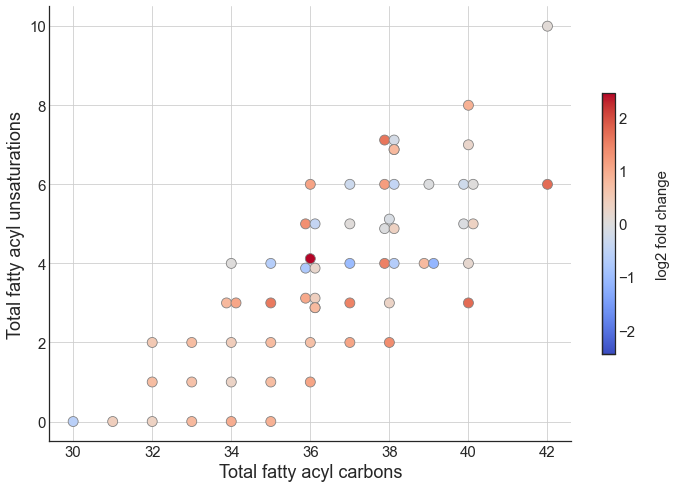

In [258]:
make_carbon_unsat_plot('PC', 0.12)

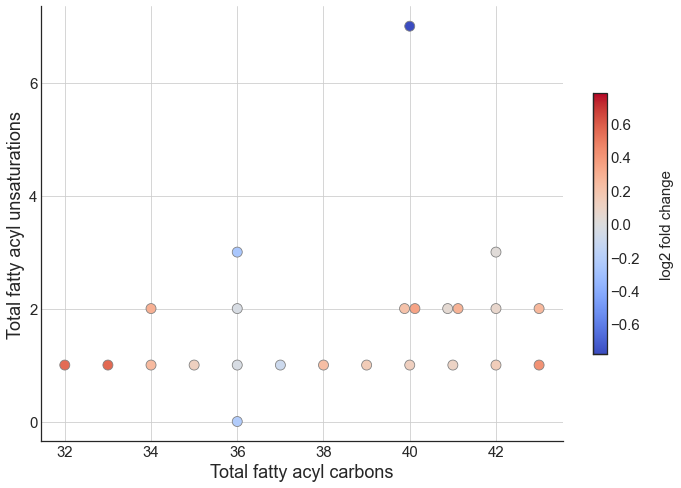

In [259]:
make_carbon_unsat_plot('SM', 0.12)

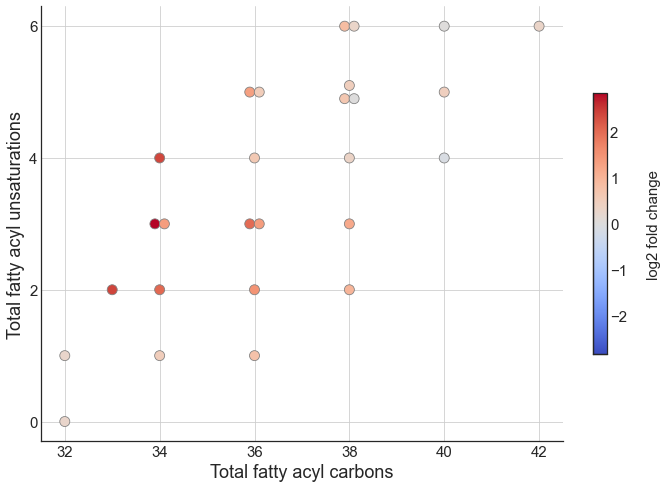

In [260]:
make_carbon_unsat_plot('Plasmanyl-PC', 0.1)

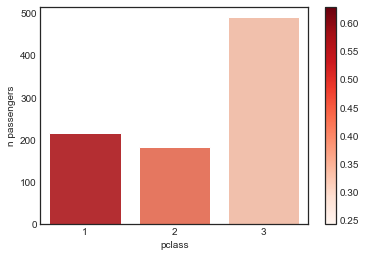

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns
titanic = sns.load_dataset("titanic")
g = titanic.groupby('pclass')
survival_rates = g['survived'].mean()
n = g.size()
norm = plt.Normalize(survival_rates.min(), survival_rates.max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax = sns.barplot(x=n.index, y=n, hue=survival_rates, palette='Reds', dodge=False)
ax.set_ylabel('n passengers')
ax.get_legend().remove()
ax.figure.colorbar(sm)

In [ ]:
# for i, cls in enumerate(['TG','PC','LysoPC', 'PI', 
#             'PE',  'SM',
#             'Plasmanyl-PC', 'Plasmenyl-PC', 'Plasmanyl-PE', 'Plasmenyl-PE']):

fig, axs = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(11, 8)
# lipid_classes = ['TG', 'PC', 'SM', 'Plasmanyl-PC']
lipid_classes = ['TG']
for i, cls in enumerate(lipid_classes):
#     ax_row, ax_col = divmod(i, 2)
#     ax = axs[ax_row][ax_col]
    ax = axs
#     df = ids.loc[(data['molec_class'] == cls) & (data['qval_sampling:ogtt'] < 0.1)]
    df = tgdf
    max_C, min_C = df['fa_carbons'].max(), df['fa_carbons'].min()
    max_unsat, min_unsat = df['fa_unsat'].max(), df['fa_unsat'].min()
    C_unsat_combos = set(ids.loc[data['molec_class'] == cls].value_counts(['fa_carbons', 'fa_unsat']).index)
    sns.scatterplot(
        data=df, x='fa_carbons', y='fa_unsat',
#         size='-log10 p-value', sizes=(10, 200),
#         size='pval_asterisks', sizes={'ns': 20, '*': 55, '**': 75, '***': 110, '****': 120},
        s=100,
#         style='pval_asterisks', markers={'ns': '^','*':'o'},
        hue='log2 FC', 
        hue_norm=TwoSlopeNorm(vcenter=0.0, vmin=df['log2 FC'].min(), vmax=df['log2 FC'].max()), 
        palette='coolwarm',  # GnBu  viridis_r
        legend=('brief' if i == 0 else False),
        edgecolor='gray',        
        ax=ax
    )
    ax.set_title(f'{cls}  n={len(df)}', fontsize=17)
    ax.set_xticks(np.arange(min_C, max_C+1, 2))
    ax.set_xticklabels([int(x) for x in np.arange(min_C, max_C+1, 2)], fontsize=15)
    ax.set_yticks(np.arange(min_unsat, max_unsat+1, 2))
    ax.set_yticklabels([int(x) for x in np.arange(min_unsat, max_unsat+1, 2)], fontsize=15)
    ax.grid(alpha=0.45)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
#     ax.set_background('gray')
#     if i == 1:
#         ax.legend(loc=(1.12, -1), markerscale=1.7, fontsize=16)
# fig.legend(loc=('lower right'), bbox_to_anchor=(1.22, 0.1), markerscale=1.2, fontsize=18)
# plt.legend(loc=(1.02, 0.2))
ax.legend(title='log2 fold change', loc=(1.01, 0.5), markerscale=1.5, fontsize=15, title_fontsize=18)

fig.suptitle('Lipids by class significant under glucose tolerance', fontsize=18)
fig.supylabel('Total fatty acyl unsaturations', fontsize=18)
fig.supxlabel('Total fatty acyl carbons', fontsize=18)
fig.set_facecolor('white')
# plt.grid()
plt.tight_layout()
sns.despine()
# plt.savefig(r'..\reports\figures\4-5-4\TG_.png', bbox_inches='tight')

In [69]:
ids.loc[data['Compound Class'] == 'TG'].value_counts(['fa_carbons', 'fa_unsat']).iloc[0:30]

fa_carbons  fa_unsat
54          4           3
58          9           3
60          11          3
58          7           3
            11          3
54          5           2
56          4           2
52          6           2
            5           2
            4           2
56          6           2
            8           2
54          7           2
58          6           2
            8           2
54          6           2
58          10          2
62          13          2
60          12          2
64          17          1
54          8           1
55          2           1
            3           1
            4           1
            8           1
56          1           1
            2           1
            3           1
62          14          1
56          5           1
dtype: int64

In [58]:
set(ids.loc[data['Compound Class'] == 'TG'].value_counts(['fa_carbons', 'fa_unsat']).index)

{(46, 0),
 (46, 1),
 (46, 2),
 (46, 3),
 (47, 0),
 (48, 0),
 (48, 1),
 (48, 2),
 (48, 3),
 (49, 0),
 (49, 1),
 (49, 2),
 (49, 3),
 (50, 0),
 (50, 1),
 (50, 2),
 (50, 3),
 (50, 4),
 (50, 5),
 (51, 1),
 (51, 2),
 (51, 3),
 (51, 4),
 (51, 5),
 (52, 0),
 (52, 1),
 (52, 2),
 (52, 3),
 (52, 4),
 (52, 5),
 (52, 6),
 (53, 1),
 (53, 2),
 (53, 3),
 (53, 4),
 (53, 5),
 (54, 0),
 (54, 1),
 (54, 2),
 (54, 3),
 (54, 4),
 (54, 5),
 (54, 6),
 (54, 7),
 (54, 8),
 (55, 2),
 (55, 3),
 (55, 4),
 (55, 8),
 (56, 1),
 (56, 2),
 (56, 3),
 (56, 4),
 (56, 5),
 (56, 6),
 (56, 7),
 (56, 8),
 (56, 9),
 (57, 2),
 (57, 8),
 (58, 2),
 (58, 3),
 (58, 4),
 (58, 6),
 (58, 7),
 (58, 8),
 (58, 9),
 (58, 10),
 (58, 11),
 (58, 12),
 (59, 3),
 (60, 3),
 (60, 4),
 (60, 10),
 (60, 11),
 (60, 12),
 (60, 13),
 (62, 13),
 (62, 14),
 (64, 17),
 (66, 18)}

<AxesSubplot:xlabel='fa_carbons', ylabel='fa_unsat'>

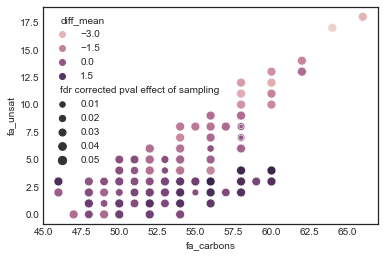

In [29]:
sns.scatterplot(data=ids.loc[ids['Compound Class'] == 'TG'], x='fa_carbons', y='fa_unsat', 
                size=q_samp, sizes=(80, 20),
                hue='diff_mean')

In [ ]:
np.arange()

<AxesSubplot:>

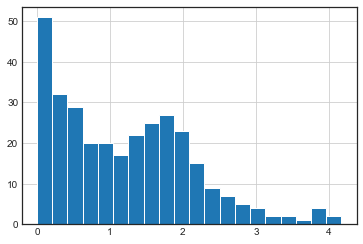

In [74]:
ids['-log10 p-value'].hist(bins=20)

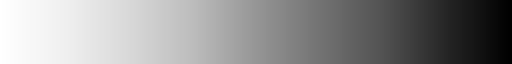

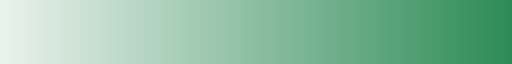

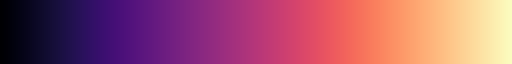

In [77]:
display(sns.color_palette('Greys', as_cmap=True))
display(sns.light_palette('seagreen', as_cmap=True))
display(sns.color_palette('magma', as_cmap=True))